<a href="https://colab.research.google.com/github/SRJ-7/Speech-Recognition-Mother-Tongue-/blob/main/Copy_of_Englishspeech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

2.3.0+cu121
2.3.0+cu121
cuda


In [ ]:
from dataclasses import dataclass

import IPython
import matplotlib.pyplot as plt

torch.random.manual_seed(0)
# audio_path = "/content/drive/MyDrive/easy_english1.wav"
# audio_path = "/content/drive/MyDrive/easy_english1_mispronounced.wav"
# audio_path = "/content/drive/MyDrive/easy_english2.wav"
# audio_path = "/content/drive/MyDrive/easy_english2_mispronounced.wav"
# audio_path = "/content/drive/MyDrive/hard_english1.wav"
# audio_path = "/content/drive/MyDrive/hard_english1_replaced.wav"
# audio_path = "/content/drive/MyDrive/hard_english2.wav"
audio_path = "/content/drive/MyDrive/hard_english2_noisy.wav"
# audio_path = "/content/drive/MyDrive/Copy of easy_smooth_english.wav"
# audio_path = "/content/drive/MyDrive/Copy of easy_mispronounce_english.wav"
# audio_path = "/content/drive/MyDrive/Copy of diff2_smooth_english.wav"
# audio_path = "/content/drive/MyDrive/Copy of diff2_mispronounce_english.wav"
SPEECH_FILE = torchaudio.utils.download_asset(audio_path)

In [ ]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
model = bundle.get_model().to(device)
labels = bundle.get_labels()
with torch.inference_mode():
    waveform, _ = torchaudio.load(SPEECH_FILE)
    emissions, _ = model(waveform.to(device))
    emissions = torch.log_softmax(emissions, dim=-1)

emission = emissions[0].cpu().detach()

print(labels)

('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


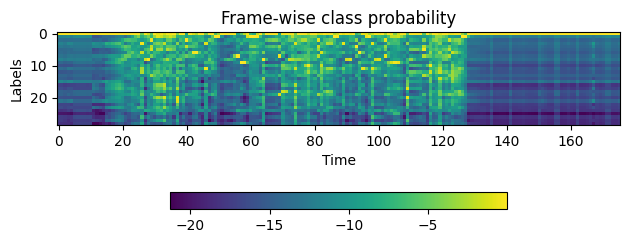

In [ ]:
def plot():
    fig, ax = plt.subplots()
    img = ax.imshow(emission.T)
    ax.set_title("Frame-wise class probability")
    ax.set_xlabel("Time")
    ax.set_ylabel("Labels")
    fig.colorbar(img, ax=ax, shrink=0.6, location="bottom")
    fig.tight_layout()


plot()

In [ ]:
if 'english1' in audio_path:
  transcript = "|HELLO|EVERYONE|"
if 'english2' in audio_path:
  transcript = "|HOW|ARE|YOU|DOING|"
if 'hard_english1' in audio_path:
  transcript = "|THE|EARTH|IS|FLAT|"
if 'hard_english2' in audio_path:
  transcript = "|THE|PEN|IS|MIGHTIER|THAN|THE|SWORD|"
if 'diff2' in audio_path:
  transcript = "|But|what|I|do|that|defines|me|"
transcript = transcript.upper()
print(transcript)
dictionary = {c: i for i, c in enumerate(labels)}

tokens = [dictionary[c] for c in transcript]
print(list(zip(transcript, tokens)))


def get_trellis(emission, tokens, blank_id=0):
    num_frame = emission.size(0)
    num_tokens = len(tokens)

    trellis = torch.zeros((num_frame, num_tokens))
    trellis[1:, 0] = torch.cumsum(emission[1:, blank_id], 0)
    trellis[0, 1:] = -float("inf")
    trellis[-num_tokens + 1 :, 0] = float("inf")

    for t in range(num_frame - 1):
        trellis[t + 1, 1:] = torch.maximum(
            # Score for staying at the same token
            trellis[t, 1:] + emission[t, blank_id],
            # Score for changing to the next token
            trellis[t, :-1] + emission[t, tokens[1:]],
        )
    return trellis


trellis = get_trellis(emission, tokens)

|THE|PEN|IS|MIGHTIER|THAN|THE|SWORD|
[('|', 1), ('T', 3), ('H', 8), ('E', 2), ('|', 1), ('P', 20), ('E', 2), ('N', 6), ('|', 1), ('I', 7), ('S', 9), ('|', 1), ('M', 14), ('I', 7), ('G', 18), ('H', 8), ('T', 3), ('I', 7), ('E', 2), ('R', 10), ('|', 1), ('T', 3), ('H', 8), ('A', 4), ('N', 6), ('|', 1), ('T', 3), ('H', 8), ('E', 2), ('|', 1), ('S', 9), ('W', 15), ('O', 5), ('R', 10), ('D', 11), ('|', 1)]


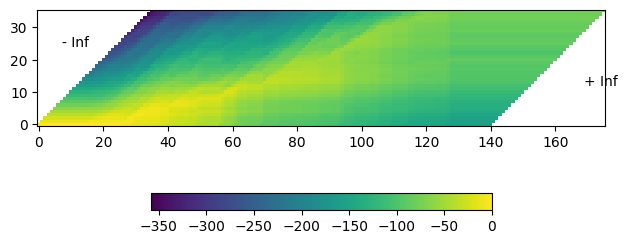

In [ ]:
def plot():
    fig, ax = plt.subplots()
    img = ax.imshow(trellis.T, origin="lower")
    ax.annotate("- Inf", (trellis.size(1) / 5, trellis.size(1) / 1.5))
    ax.annotate("+ Inf", (trellis.size(0) - trellis.size(1) / 5, trellis.size(1) / 3))
    fig.colorbar(img, ax=ax, shrink=0.6, location="bottom")
    fig.tight_layout()


plot()

Point(token_index=0, time_index=0, score=0.9999582767486572)
Point(token_index=0, time_index=1, score=0.9999510049819946)
Point(token_index=0, time_index=2, score=0.999966025352478)
Point(token_index=0, time_index=3, score=0.9999394416809082)
Point(token_index=0, time_index=4, score=0.9999452829360962)
Point(token_index=0, time_index=5, score=0.9999595880508423)
Point(token_index=0, time_index=6, score=0.9999537467956543)
Point(token_index=0, time_index=7, score=0.9999536275863647)
Point(token_index=0, time_index=8, score=0.9999536275863647)
Point(token_index=0, time_index=9, score=0.9999592304229736)
Point(token_index=0, time_index=10, score=0.9999536275863647)
Point(token_index=0, time_index=11, score=0.9999294281005859)
Point(token_index=0, time_index=12, score=0.9999526739120483)
Point(token_index=0, time_index=13, score=0.999956488609314)
Point(token_index=0, time_index=14, score=0.9999240636825562)
Point(token_index=0, time_index=15, score=0.9993353486061096)
Point(token_index=0,

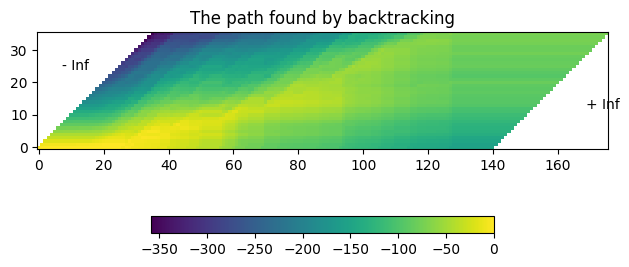

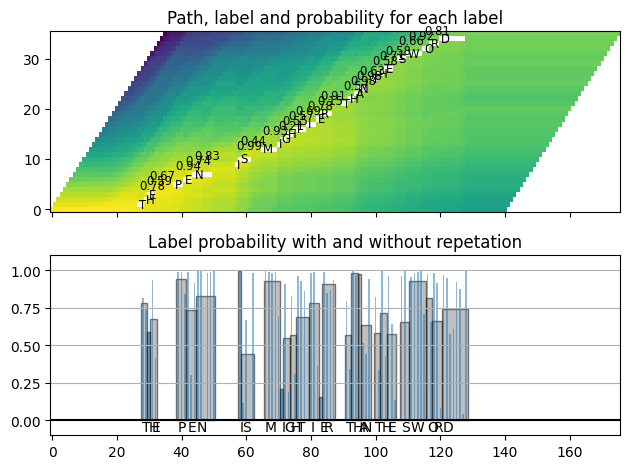

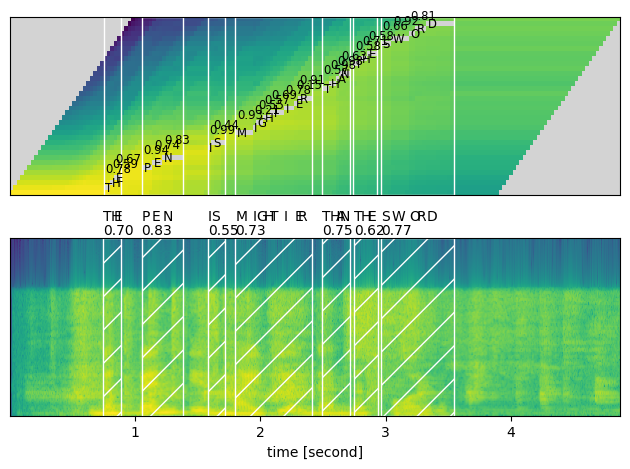

In [ ]:
def plot():
    fig, ax = plt.subplots()
    img = ax.imshow(trellis.T, origin="lower")
    ax.annotate("- Inf", (trellis.size(1) / 5, trellis.size(1) / 1.5))
    ax.annotate("+ Inf", (trellis.size(0) - trellis.size(1) / 5, trellis.size(1) / 3))
    fig.colorbar(img, ax=ax, shrink=0.6, location="bottom")
    fig.tight_layout()


plot()

from dataclasses import dataclass

@dataclass
class Point:
    token_index: int
    time_index: int
    score: float


def backtrack(trellis, emission, tokens, blank_id=0):
    t, j = trellis.size(0) - 1, trellis.size(1) - 1

    path = [Point(j, t, emission[t, blank_id].exp().item())]
    while j > 0:
        # Should not happen but just in case
        assert t > 0

        # 1. Figure out if the current position was stay or change
        # Frame-wise score of stay vs change
        p_stay = emission[t - 1, blank_id]
        p_change = emission[t - 1, tokens[j]]

        # Context-aware score for stay vs change
        stayed = trellis[t - 1, j] + p_stay
        changed = trellis[t - 1, j - 1] + p_change

        # Update position
        t -= 1
        if changed > stayed:
            j -= 1

        # Store the path with frame-wise probability.
        prob = (p_change if changed > stayed else p_stay).exp().item()
        path.append(Point(j, t, prob))

    # Now j == 0, which means, it reached the SoS.
    # Fill up the rest for the sake of visualization
    while t > 0:
        prob = emission[t - 1, blank_id].exp().item()
        path.append(Point(j, t - 1, prob))
        t -= 1

    return path[::-1]


path = backtrack(trellis, emission, tokens)
for p in path:
    print(p)

def plot_trellis_with_path(trellis, path):
    # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    for _, p in enumerate(path):
        trellis_with_path[p.time_index, p.token_index] = float("nan")
    plt.imshow(trellis_with_path.T, origin="lower")
    plt.title("The path found by backtracking")
    plt.tight_layout()


plot_trellis_with_path(trellis, path)

# Merge the labels
@dataclass
class Segment:
    label: str
    start: int
    end: int
    score: float

    def _repr_(self):
        return f"{self.label}\t({self.score:4.2f}): [{self.start:5d}, {self.end:5d})"

    @property
    def length(self):
        return self.end - self.start


def merge_repeats(path):
    i1, i2 = 0, 0
    segments = []
    while i1 < len(path):
        while i2 < len(path) and path[i1].token_index == path[i2].token_index:
            i2 += 1
        score = sum(path[k].score for k in range(i1, i2)) / (i2 - i1)
        segments.append(
            Segment(
                transcript[path[i1].token_index],
                path[i1].time_index,
                path[i2 - 1].time_index + 1,
                score,
            )
        )
        i1 = i2
    return segments


segments = merge_repeats(path)
for seg in segments:
    print(seg)

def plot_trellis_with_segments(trellis, segments, transcript):
    # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != "|":
            trellis_with_path[seg.start : seg.end, i] = float("nan")

    fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True)
    ax1.set_title("Path, label and probability for each label")
    ax1.imshow(trellis_with_path.T, origin="lower", aspect="auto")

    for i, seg in enumerate(segments):
        if seg.label != "|":
            ax1.annotate(seg.label, (seg.start, i - 0.7), size="small")
            ax1.annotate(f"{seg.score:.2f}", (seg.start, i + 3), size="small")

    ax2.set_title("Label probability with and without repetation")
    xs, hs, ws = [], [], []
    for seg in segments:
        if seg.label != "|":
            xs.append((seg.end + seg.start) / 2 + 0.4)
            hs.append(seg.score)
            ws.append(seg.end - seg.start)
            ax2.annotate(seg.label, (seg.start + 0.8, -0.07))
    ax2.bar(xs, hs, width=ws, color="gray", alpha=0.5, edgecolor="black")

    xs, hs = [], []
    for p in path:
        label = transcript[p.token_index]
        if label != "|":
            xs.append(p.time_index + 1)
            hs.append(p.score)

    ax2.bar(xs, hs, width=0.5, alpha=0.5)
    ax2.axhline(0, color="black")
    ax2.grid(True, axis="y")
    ax2.set_ylim(-0.1, 1.1)
    fig.tight_layout()


plot_trellis_with_segments(trellis, segments, transcript)

# Merge words
def merge_words(segments, separator="|"):
    words = []
    i1, i2 = 0, 0
    while i1 < len(segments):
        if i2 >= len(segments) or segments[i2].label == separator:
            if i1 != i2:
                segs = segments[i1:i2]
                word = "".join([seg.label for seg in segs])
                score = sum(seg.score * seg.length for seg in segs) / sum(seg.length for seg in segs)
                words.append(Segment(word, segments[i1].start, segments[i2 - 1].end, score))
            i1 = i2 + 1
            i2 = i1
        else:
            i2 += 1
    return words


word_segments = merge_words(segments)
for word in word_segments:
    print(word)

import librosa

# Load the audio file
waveform, sample_rate = librosa.load(audio_path)

def plot_alignments(trellis, segments, word_segments, waveform, sample_rate=16000):
    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != "|":
            trellis_with_path[seg.start : seg.end, i] = float("nan")

    fig, [ax1, ax2] = plt.subplots(2, 1)

    ax1.imshow(trellis_with_path.T, origin="lower", aspect="auto")
    ax1.set_facecolor("lightgray")
    ax1.set_xticks([])
    ax1.set_yticks([])

    for word in word_segments:
        ax1.axvspan(word.start - 0.5, word.end - 0.5, edgecolor="white", facecolor="none")

    for i, seg in enumerate(segments):
        if seg.label != "|":
            ax1.annotate(seg.label, (seg.start, i - 0.7), size="small")
            ax1.annotate(f"{seg.score:.2f}", (seg.start, i + 3), size="small")

    # The original waveform
    ratio = len(waveform) / sample_rate / trellis.size(0)
    ax2.specgram(waveform, Fs=sample_rate)
    for word in word_segments:
        x0 = ratio * word.start
        x1 = ratio * word.end
        ax2.axvspan(x0, x1, facecolor="none", edgecolor="white", hatch="/")
        ax2.annotate(f"{word.score:.2f}", (x0, sample_rate * 0.51), annotation_clip=False)

    for seg in segments:
        if seg.label != "|":
            ax2.annotate(seg.label, (seg.start * ratio, sample_rate * 0.55), annotation_clip=False)
    ax2.set_xlabel("time [second]")
    ax2.set_yticks([])
    fig.tight_layout()


plot_alignments(trellis, segments, word_segments, waveform)

sample_rate = 16000
def display_segment(i):
    ratio = len(waveform) / trellis.size(0)
    word = word_segments[i]
    x0 = int(ratio * word.start)
    x1 = int(ratio * word.end)
    print(f"{word.label} ({word.score:.2f}): {x0 / sample_rate:.3f} - {x1 / sample_rate:.3f} sec")
    segment = waveform[x0:x1]
    return IPython.display.Audio(segment, rate=sample_rate)

import IPython
# Generate the audio for each segment
print(transcript)
IPython.display.Audio(audio_path)



# display_segment(2)

In [ ]:
display_segment(0)

THE (0.70): 0.748 - 0.887 sec


In [ ]:
display_segment(1)


PEN (0.83): 1.053 - 1.386 sec


In [ ]:
display_segment(2)

IS (0.55): 1.580 - 1.719 sec


In [ ]:
display_segment(3)

MIGHTIER (0.73): 1.802 - 2.412 sec


In [ ]:
display_segment(4)

THAN (0.75): 2.495 - 2.716 sec


In [ ]:
display_segment(5)

THE (0.62): 2.744 - 2.938 sec


In [ ]:
display_segment(6)

SWORD (0.77): 2.966 - 3.548 sec


**hard_english2_noisy**

In [ ]:
display_segment(0)

THE (0.70): 0.748 - 0.887 sec


In [ ]:
display_segment(1)


PEN (0.83): 1.053 - 1.386 sec


In [ ]:
display_segment(2)

IS (0.55): 1.580 - 1.719 sec


In [ ]:
display_segment(3)

MIGHTIER (0.73): 1.802 - 2.412 sec


In [ ]:
display_segment(4)

THAN (0.75): 2.495 - 2.716 sec


In [ ]:
display_segment(5)

THE (0.62): 2.744 - 2.938 sec


In [ ]:
display_segment(6)

SWORD (0.77): 2.966 - 3.548 sec


**hard_english2**

In [ ]:
display_segment(0)

THE (0.84): 0.970 - 1.220 sec


In [ ]:
display_segment(1)


PEN (0.91): 1.358 - 1.691 sec


In [ ]:
display_segment(2)

IS (0.66): 2.051 - 2.218 sec


In [ ]:
display_segment(3)

MIGHTIER (0.87): 2.356 - 3.077 sec


In [ ]:
display_segment(4)

THAN (0.94): 3.188 - 3.521 sec


In [ ]:
display_segment(5)

THE (0.73): 3.631 - 3.881 sec


In [ ]:
display_segment(6)

SWORD (0.82): 3.909 - 4.519 sec


**easy_english2_mispronounced**

In [ ]:
display_segment(0)

HOW (0.95): 0.610 - 0.942 sec


In [ ]:
display_segment(1)


ARE (0.86): 0.970 - 1.913 sec


In [ ]:
display_segment(2)

YOU (0.90): 1.940 - 2.800 sec


In [ ]:
display_segment(3)

DOING (0.95): 3.104 - 3.576 sec


#### **easy_english2**

In [ ]:
display_segment(0)

HOW (0.70): 0.444 - 0.748 sec


In [ ]:
display_segment(1)


ARE (0.78): 0.776 - 1.414 sec


In [ ]:
display_segment(2)

YOU (0.97): 1.691 - 1.968 sec


In [ ]:
display_segment(3)

DOING (0.77): 2.301 - 2.772 sec


**easy_english1_mispronounced**

In [ ]:
display_segment(0)

HELLO (0.92): 0.583 - 1.083 sec


In [ ]:
display_segment(1)


EVERYONE (0.86): 1.278 - 1.861 sec


**easy_english1**

In [ ]:
display_segment(0)

HELLO (0.97): 0.499 - 0.999 sec


In [ ]:
display_segment(1)


EVERYONE (0.86): 1.304 - 1.943 sec


In [ ]:
from dataclasses import dataclass

import IPython
import matplotlib.pyplot as plt

torch.random.manual_seed(0)
audio_path = "/content/drive/MyDrive/hard_english2_noisy.wav"
SPEECH_FILE = torchaudio.utils.download_asset(audio_path)

In [ ]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
model = bundle.get_model().to(device)
labels = bundle.get_labels()
with torch.inference_mode():
    waveform, _ = torchaudio.load(SPEECH_FILE)
    emissions, _ = model(waveform.to(device))
    emissions = torch.log_softmax(emissions, dim=-1)

emission = emissions[0].cpu().detach()

print(labels)

('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


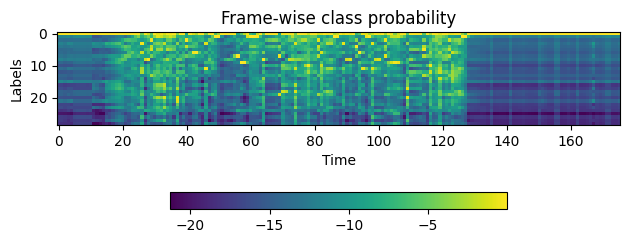

In [ ]:
def plot():
    fig, ax = plt.subplots()
    img = ax.imshow(emission.T)
    ax.set_title("Frame-wise class probability")
    ax.set_xlabel("Time")
    ax.set_ylabel("Labels")
    fig.colorbar(img, ax=ax, shrink=0.6, location="bottom")
    fig.tight_layout()


plot()

In [ ]:
if 'english1' in audio_path:
  transcript = "|HELLO|EVERYONE|"
if 'english2' in audio_path:
  transcript = "|HOW|ARE|YOU|DOING|"
if 'hard_english1' in audio_path:
  transcript = "|THE|EARTH|IS|FLAT|"
if 'hard_english2' in audio_path:
  transcript = "|THE|PEN|IS|MIGHTIER|THAN|THE|SWORD|"
if 'diff2' in audio_path:
  transcript = "|But|what|I|do|that|defines|me|"
transcript = transcript.upper()
print(transcript)
dictionary = {c: i for i, c in enumerate(labels)}

tokens = [dictionary[c] for c in transcript]
print(list(zip(transcript, tokens)))


def get_trellis(emission, tokens, blank_id=0):
    num_frame = emission.size(0)
    num_tokens = len(tokens)

    trellis = torch.zeros((num_frame, num_tokens))
    trellis[1:, 0] = torch.cumsum(emission[1:, blank_id], 0)
    trellis[0, 1:] = -float("inf")
    trellis[-num_tokens + 1 :, 0] = float("inf")

    for t in range(num_frame - 1):
        trellis[t + 1, 1:] = torch.maximum(
            # Score for staying at the same token
            trellis[t, 1:] + emission[t, blank_id],
            # Score for changing to the next token
            trellis[t, :-1] + emission[t, tokens[1:]],
        )
    return trellis


trellis = get_trellis(emission, tokens)

|THE|PEN|IS|MIGHTIER|THAN|THE|SWORD|
[('|', 1), ('T', 3), ('H', 8), ('E', 2), ('|', 1), ('P', 20), ('E', 2), ('N', 6), ('|', 1), ('I', 7), ('S', 9), ('|', 1), ('M', 14), ('I', 7), ('G', 18), ('H', 8), ('T', 3), ('I', 7), ('E', 2), ('R', 10), ('|', 1), ('T', 3), ('H', 8), ('A', 4), ('N', 6), ('|', 1), ('T', 3), ('H', 8), ('E', 2), ('|', 1), ('S', 9), ('W', 15), ('O', 5), ('R', 10), ('D', 11), ('|', 1)]


Point(token_index=0, time_index=0, score=0.9999582767486572)
Point(token_index=0, time_index=1, score=0.9999510049819946)
Point(token_index=0, time_index=2, score=0.999966025352478)
Point(token_index=0, time_index=3, score=0.9999394416809082)
Point(token_index=0, time_index=4, score=0.9999452829360962)
Point(token_index=0, time_index=5, score=0.9999595880508423)
Point(token_index=0, time_index=6, score=0.9999537467956543)
Point(token_index=0, time_index=7, score=0.9999536275863647)
Point(token_index=0, time_index=8, score=0.9999536275863647)
Point(token_index=0, time_index=9, score=0.9999592304229736)
Point(token_index=0, time_index=10, score=0.9999536275863647)
Point(token_index=0, time_index=11, score=0.9999294281005859)
Point(token_index=0, time_index=12, score=0.9999526739120483)
Point(token_index=0, time_index=13, score=0.999956488609314)
Point(token_index=0, time_index=14, score=0.9999240636825562)
Point(token_index=0, time_index=15, score=0.9993353486061096)
Point(token_index=0,

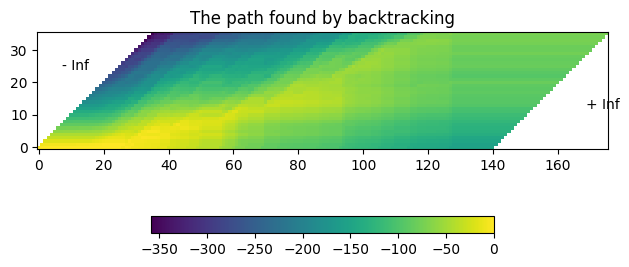

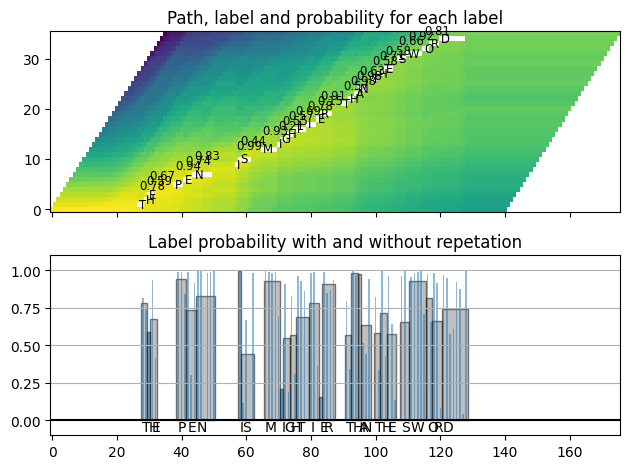

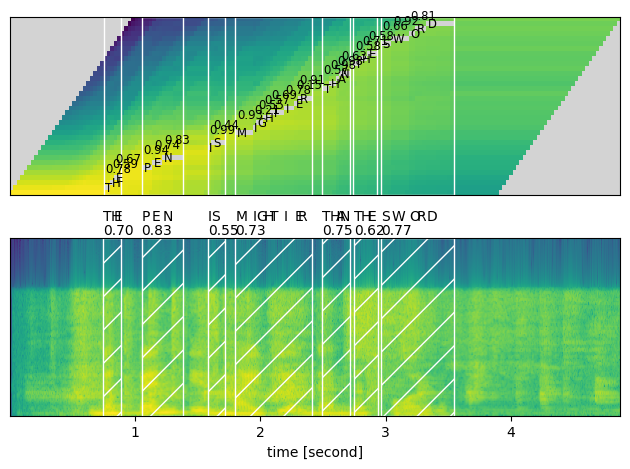

In [ ]:
def plot():
    fig, ax = plt.subplots()
    img = ax.imshow(trellis.T, origin="lower")
    ax.annotate("- Inf", (trellis.size(1) / 5, trellis.size(1) / 1.5))
    ax.annotate("+ Inf", (trellis.size(0) - trellis.size(1) / 5, trellis.size(1) / 3))
    fig.colorbar(img, ax=ax, shrink=0.6, location="bottom")
    fig.tight_layout()


plot()

from dataclasses import dataclass

@dataclass
class Point:
    token_index: int
    time_index: int
    score: float


def backtrack(trellis, emission, tokens, blank_id=0):
    t, j = trellis.size(0) - 1, trellis.size(1) - 1

    path = [Point(j, t, emission[t, blank_id].exp().item())]
    while j > 0:
        # Should not happen but just in case
        assert t > 0

        # 1. Figure out if the current position was stay or change
        # Frame-wise score of stay vs change
        p_stay = emission[t - 1, blank_id]
        p_change = emission[t - 1, tokens[j]]

        # Context-aware score for stay vs change
        stayed = trellis[t - 1, j] + p_stay
        changed = trellis[t - 1, j - 1] + p_change

        # Update position
        t -= 1
        if changed > stayed:
            j -= 1

        # Store the path with frame-wise probability.
        prob = (p_change if changed > stayed else p_stay).exp().item()
        path.append(Point(j, t, prob))

    # Now j == 0, which means, it reached the SoS.
    # Fill up the rest for the sake of visualization
    while t > 0:
        prob = emission[t - 1, blank_id].exp().item()
        path.append(Point(j, t - 1, prob))
        t -= 1

    return path[::-1]


path = backtrack(trellis, emission, tokens)
for p in path:
    print(p)

def plot_trellis_with_path(trellis, path):
    # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    for _, p in enumerate(path):
        trellis_with_path[p.time_index, p.token_index] = float("nan")
    plt.imshow(trellis_with_path.T, origin="lower")
    plt.title("The path found by backtracking")
    plt.tight_layout()


plot_trellis_with_path(trellis, path)

# Merge the labels
@dataclass
class Segment:
    label: str
    start: int
    end: int
    score: float

    def _repr_(self):
        return f"{self.label}\t({self.score:4.2f}): [{self.start:5d}, {self.end:5d})"

    @property
    def length(self):
        return self.end - self.start


def merge_repeats(path):
    i1, i2 = 0, 0
    segments = []
    while i1 < len(path):
        while i2 < len(path) and path[i1].token_index == path[i2].token_index:
            i2 += 1
        score = sum(path[k].score for k in range(i1, i2)) / (i2 - i1)
        segments.append(
            Segment(
                transcript[path[i1].token_index],
                path[i1].time_index,
                path[i2 - 1].time_index + 1,
                score,
            )
        )
        i1 = i2
    return segments


segments = merge_repeats(path)
for seg in segments:
    print(seg)

def plot_trellis_with_segments(trellis, segments, transcript):
    # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != "|":
            trellis_with_path[seg.start : seg.end, i] = float("nan")

    fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True)
    ax1.set_title("Path, label and probability for each label")
    ax1.imshow(trellis_with_path.T, origin="lower", aspect="auto")

    for i, seg in enumerate(segments):
        if seg.label != "|":
            ax1.annotate(seg.label, (seg.start, i - 0.7), size="small")
            ax1.annotate(f"{seg.score:.2f}", (seg.start, i + 3), size="small")

    ax2.set_title("Label probability with and without repetation")
    xs, hs, ws = [], [], []
    for seg in segments:
        if seg.label != "|":
            xs.append((seg.end + seg.start) / 2 + 0.4)
            hs.append(seg.score)
            ws.append(seg.end - seg.start)
            ax2.annotate(seg.label, (seg.start + 0.8, -0.07))
    ax2.bar(xs, hs, width=ws, color="gray", alpha=0.5, edgecolor="black")

    xs, hs = [], []
    for p in path:
        label = transcript[p.token_index]
        if label != "|":
            xs.append(p.time_index + 1)
            hs.append(p.score)

    ax2.bar(xs, hs, width=0.5, alpha=0.5)
    ax2.axhline(0, color="black")
    ax2.grid(True, axis="y")
    ax2.set_ylim(-0.1, 1.1)
    fig.tight_layout()


plot_trellis_with_segments(trellis, segments, transcript)

# Merge words
def merge_words(segments, separator="|"):
    words = []
    i1, i2 = 0, 0
    while i1 < len(segments):
        if i2 >= len(segments) or segments[i2].label == separator:
            if i1 != i2:
                segs = segments[i1:i2]
                word = "".join([seg.label for seg in segs])
                score = sum(seg.score * seg.length for seg in segs) / sum(seg.length for seg in segs)
                words.append(Segment(word, segments[i1].start, segments[i2 - 1].end, score))
            i1 = i2 + 1
            i2 = i1
        else:
            i2 += 1
    return words


word_segments = merge_words(segments)
for word in word_segments:
    print(word)

import librosa

# Load the audio file
waveform, sample_rate = librosa.load(audio_path)

def plot_alignments(trellis, segments, word_segments, waveform, sample_rate=16000):
    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != "|":
            trellis_with_path[seg.start : seg.end, i] = float("nan")

    fig, [ax1, ax2] = plt.subplots(2, 1)

    ax1.imshow(trellis_with_path.T, origin="lower", aspect="auto")
    ax1.set_facecolor("lightgray")
    ax1.set_xticks([])
    ax1.set_yticks([])

    for word in word_segments:
        ax1.axvspan(word.start - 0.5, word.end - 0.5, edgecolor="white", facecolor="none")

    for i, seg in enumerate(segments):
        if seg.label != "|":
            ax1.annotate(seg.label, (seg.start, i - 0.7), size="small")
            ax1.annotate(f"{seg.score:.2f}", (seg.start, i + 3), size="small")

    # The original waveform
    ratio = len(waveform) / sample_rate / trellis.size(0)
    ax2.specgram(waveform, Fs=sample_rate)
    for word in word_segments:
        x0 = ratio * word.start
        x1 = ratio * word.end
        ax2.axvspan(x0, x1, facecolor="none", edgecolor="white", hatch="/")
        ax2.annotate(f"{word.score:.2f}", (x0, sample_rate * 0.51), annotation_clip=False)

    for seg in segments:
        if seg.label != "|":
            ax2.annotate(seg.label, (seg.start * ratio, sample_rate * 0.55), annotation_clip=False)
    ax2.set_xlabel("time [second]")
    ax2.set_yticks([])
    fig.tight_layout()


plot_alignments(trellis, segments, word_segments, waveform)

sample_rate = 16000
def display_segment(i):
    ratio = len(waveform) / trellis.size(0)
    word = word_segments[i]
    x0 = int(ratio * word.start)
    x1 = int(ratio * word.end)
    print(f"{word.label} ({word.score:.2f}): {x0 / sample_rate:.3f} - {x1 / sample_rate:.3f} sec")
    segment = waveform[x0:x1]
    return IPython.display.Audio(segment, rate=sample_rate)

import IPython
# Generate the audio for each segment
print(transcript)
IPython.display.Audio(audio_path)



# display_segment(2)

In [ ]:
display_segment(0)

THE (0.70): 0.748 - 0.887 sec


In [ ]:
display_segment(1)

PEN (0.83): 1.053 - 1.386 sec


In [ ]:
display_segment(2)

IS (0.55): 1.580 - 1.719 sec


In [ ]:
display_segment(3)

MIGHTIER (0.73): 1.802 - 2.412 sec


In [ ]:
display_segment(4)

THAN (0.75): 2.495 - 2.716 sec


In [ ]:
display_segment(5)

THE (0.62): 2.744 - 2.938 sec


In [ ]:
display_segment(6)

SWORD (0.77): 2.966 - 3.548 sec


In [ ]:
from dataclasses import dataclass

import IPython
import matplotlib.pyplot as plt

torch.random.manual_seed(0)
# audio_path = "/content/drive/MyDrive/easy_english1.wav"
# audio_path = "/content/drive/MyDrive/easy_english1_mispronounced.wav"
audio_path = "/content/drive/MyDrive/easy_english2.wav"
# audio_path = "/content/drive/MyDrive/easy_english2_mispronounced.wav"
# audio_path = "/content/drive/MyDrive/hard_english1.wav"
# audio_path = "/content/drive/MyDrive/hard_english1_replaced.wav"
# audio_path = "/content/drive/MyDrive/hard_english2.wav"
# audio_path = "/content/drive/MyDrive/hard_english2_noisy.wav"
# audio_path = "/content/drive/MyDrive/Copy of easy_smooth_english.wav"
# audio_path = "/content/drive/MyDrive/Copy of easy_mispronounce_english.wav"
# audio_path = "/content/drive/MyDrive/Copy of diff2_smooth_english.wav"
# audio_path = "/content/drive/MyDrive/Copy of diff2_mispronounce_english.wav"
SPEECH_FILE = torchaudio.utils.download_asset(audio_path)

In [ ]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
model = bundle.get_model().to(device)
labels = bundle.get_labels()
with torch.inference_mode():
    waveform, _ = torchaudio.load(SPEECH_FILE)
    emissions, _ = model(waveform.to(device))
    emissions = torch.log_softmax(emissions, dim=-1)

emission = emissions[0].cpu().detach()

print(labels)

('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


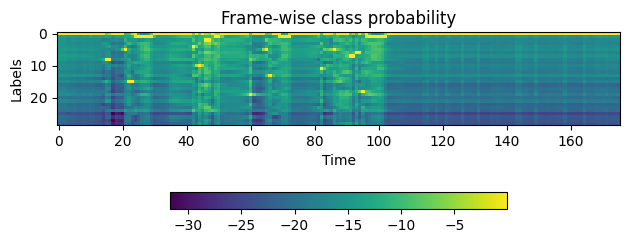

In [ ]:
def plot():
    fig, ax = plt.subplots()
    img = ax.imshow(emission.T)
    ax.set_title("Frame-wise class probability")
    ax.set_xlabel("Time")
    ax.set_ylabel("Labels")
    fig.colorbar(img, ax=ax, shrink=0.6, location="bottom")
    fig.tight_layout()


plot()

In [ ]:
if 'english1' in audio_path:
  transcript = "|HELLO|EVERYONE|"
if 'english2' in audio_path:
  transcript = "|HOW|ARE|YOU|DOING|"
if 'hard_english1' in audio_path:
  transcript = "|THE|EARTH|IS|FLAT|"
if 'hard_english2' in audio_path:
  transcript = "|THE|PEN|IS|MIGHTIER|THAN|THE|SWORD|"
if 'diff2' in audio_path:
  transcript = "|But|what|I|do|that|defines|me|"
transcript = transcript.upper()
print(transcript)
dictionary = {c: i for i, c in enumerate(labels)}

tokens = [dictionary[c] for c in transcript]
print(list(zip(transcript, tokens)))


def get_trellis(emission, tokens, blank_id=0):
    num_frame = emission.size(0)
    num_tokens = len(tokens)

    trellis = torch.zeros((num_frame, num_tokens))
    trellis[1:, 0] = torch.cumsum(emission[1:, blank_id], 0)
    trellis[0, 1:] = -float("inf")
    trellis[-num_tokens + 1 :, 0] = float("inf")

    for t in range(num_frame - 1):
        trellis[t + 1, 1:] = torch.maximum(
            # Score for staying at the same token
            trellis[t, 1:] + emission[t, blank_id],
            # Score for changing to the next token
            trellis[t, :-1] + emission[t, tokens[1:]],
        )
    return trellis


trellis = get_trellis(emission, tokens)

|HOW|ARE|YOU|DOING|
[('|', 1), ('H', 8), ('O', 5), ('W', 15), ('|', 1), ('A', 4), ('R', 10), ('E', 2), ('|', 1), ('Y', 19), ('O', 5), ('U', 13), ('|', 1), ('D', 11), ('O', 5), ('I', 7), ('N', 6), ('G', 18), ('|', 1)]


Point(token_index=0, time_index=0, score=0.9999951124191284)
Point(token_index=0, time_index=1, score=0.9999951124191284)
Point(token_index=0, time_index=2, score=0.9999954700469971)
Point(token_index=0, time_index=3, score=0.9999977350234985)
Point(token_index=0, time_index=4, score=0.9999971389770508)
Point(token_index=0, time_index=5, score=0.9999969005584717)
Point(token_index=0, time_index=6, score=0.9999980926513672)
Point(token_index=0, time_index=7, score=0.9999984502792358)
Point(token_index=0, time_index=8, score=0.9999977350234985)
Point(token_index=0, time_index=9, score=0.9999984502792358)
Point(token_index=0, time_index=10, score=0.9999969005584717)
Point(token_index=0, time_index=11, score=0.9999980926513672)
Point(token_index=0, time_index=12, score=0.9999984502792358)
Point(token_index=0, time_index=13, score=0.9999980926513672)
Point(token_index=0, time_index=14, score=0.9999929666519165)
Point(token_index=0, time_index=15, score=0.998528242111206)
Point(token_index=1

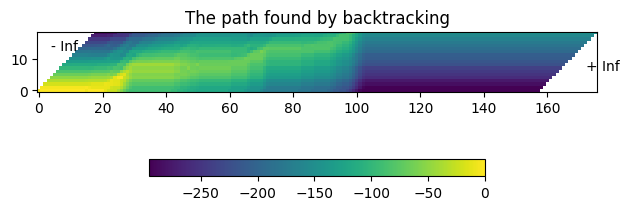

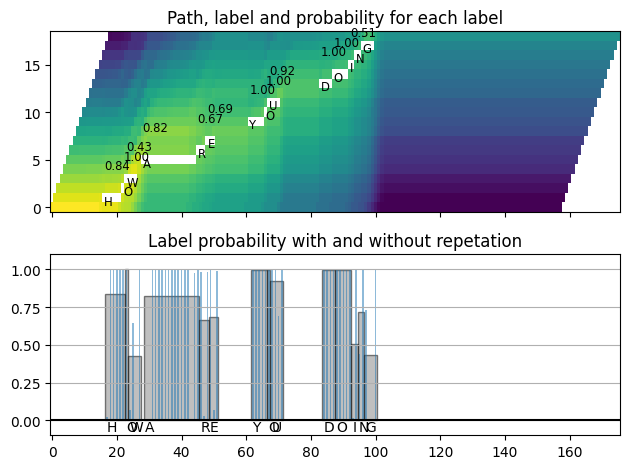

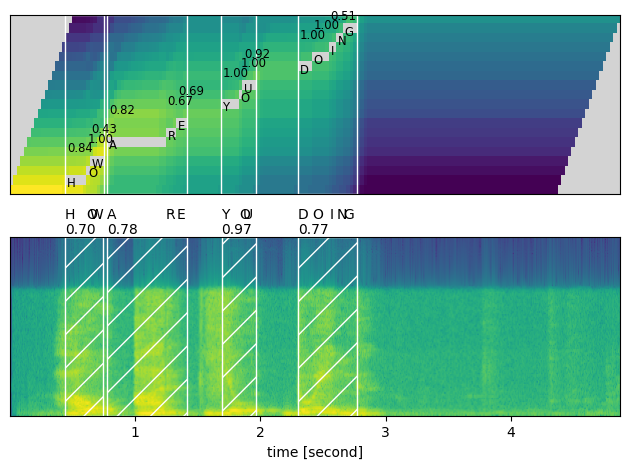

In [ ]:
def plot():
    fig, ax = plt.subplots()
    img = ax.imshow(trellis.T, origin="lower")
    ax.annotate("- Inf", (trellis.size(1) / 5, trellis.size(1) / 1.5))
    ax.annotate("+ Inf", (trellis.size(0) - trellis.size(1) / 5, trellis.size(1) / 3))
    fig.colorbar(img, ax=ax, shrink=0.6, location="bottom")
    fig.tight_layout()


plot()

from dataclasses import dataclass

@dataclass
class Point:
    token_index: int
    time_index: int
    score: float


def backtrack(trellis, emission, tokens, blank_id=0):
    t, j = trellis.size(0) - 1, trellis.size(1) - 1

    path = [Point(j, t, emission[t, blank_id].exp().item())]
    while j > 0:
        # Should not happen but just in case
        assert t > 0

        # 1. Figure out if the current position was stay or change
        # Frame-wise score of stay vs change
        p_stay = emission[t - 1, blank_id]
        p_change = emission[t - 1, tokens[j]]

        # Context-aware score for stay vs change
        stayed = trellis[t - 1, j] + p_stay
        changed = trellis[t - 1, j - 1] + p_change

        # Update position
        t -= 1
        if changed > stayed:
            j -= 1

        # Store the path with frame-wise probability.
        prob = (p_change if changed > stayed else p_stay).exp().item()
        path.append(Point(j, t, prob))

    # Now j == 0, which means, it reached the SoS.
    # Fill up the rest for the sake of visualization
    while t > 0:
        prob = emission[t - 1, blank_id].exp().item()
        path.append(Point(j, t - 1, prob))
        t -= 1

    return path[::-1]


path = backtrack(trellis, emission, tokens)
for p in path:
    print(p)

def plot_trellis_with_path(trellis, path):
    # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    for _, p in enumerate(path):
        trellis_with_path[p.time_index, p.token_index] = float("nan")
    plt.imshow(trellis_with_path.T, origin="lower")
    plt.title("The path found by backtracking")
    plt.tight_layout()


plot_trellis_with_path(trellis, path)

# Merge the labels
@dataclass
class Segment:
    label: str
    start: int
    end: int
    score: float

    def _repr_(self):
        return f"{self.label}\t({self.score:4.2f}): [{self.start:5d}, {self.end:5d})"

    @property
    def length(self):
        return self.end - self.start


def merge_repeats(path):
    i1, i2 = 0, 0
    segments = []
    while i1 < len(path):
        while i2 < len(path) and path[i1].token_index == path[i2].token_index:
            i2 += 1
        score = sum(path[k].score for k in range(i1, i2)) / (i2 - i1)
        segments.append(
            Segment(
                transcript[path[i1].token_index],
                path[i1].time_index,
                path[i2 - 1].time_index + 1,
                score,
            )
        )
        i1 = i2
    return segments


segments = merge_repeats(path)
for seg in segments:
    print(seg)

def plot_trellis_with_segments(trellis, segments, transcript):
    # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != "|":
            trellis_with_path[seg.start : seg.end, i] = float("nan")

    fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True)
    ax1.set_title("Path, label and probability for each label")
    ax1.imshow(trellis_with_path.T, origin="lower", aspect="auto")

    for i, seg in enumerate(segments):
        if seg.label != "|":
            ax1.annotate(seg.label, (seg.start, i - 0.7), size="small")
            ax1.annotate(f"{seg.score:.2f}", (seg.start, i + 3), size="small")

    ax2.set_title("Label probability with and without repetation")
    xs, hs, ws = [], [], []
    for seg in segments:
        if seg.label != "|":
            xs.append((seg.end + seg.start) / 2 + 0.4)
            hs.append(seg.score)
            ws.append(seg.end - seg.start)
            ax2.annotate(seg.label, (seg.start + 0.8, -0.07))
    ax2.bar(xs, hs, width=ws, color="gray", alpha=0.5, edgecolor="black")

    xs, hs = [], []
    for p in path:
        label = transcript[p.token_index]
        if label != "|":
            xs.append(p.time_index + 1)
            hs.append(p.score)

    ax2.bar(xs, hs, width=0.5, alpha=0.5)
    ax2.axhline(0, color="black")
    ax2.grid(True, axis="y")
    ax2.set_ylim(-0.1, 1.1)
    fig.tight_layout()


plot_trellis_with_segments(trellis, segments, transcript)

# Merge words
def merge_words(segments, separator="|"):
    words = []
    i1, i2 = 0, 0
    while i1 < len(segments):
        if i2 >= len(segments) or segments[i2].label == separator:
            if i1 != i2:
                segs = segments[i1:i2]
                word = "".join([seg.label for seg in segs])
                score = sum(seg.score * seg.length for seg in segs) / sum(seg.length for seg in segs)
                words.append(Segment(word, segments[i1].start, segments[i2 - 1].end, score))
            i1 = i2 + 1
            i2 = i1
        else:
            i2 += 1
    return words


word_segments = merge_words(segments)
for word in word_segments:
    print(word)

import librosa

# Load the audio file
waveform, sample_rate = librosa.load(audio_path)

def plot_alignments(trellis, segments, word_segments, waveform, sample_rate=16000):
    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != "|":
            trellis_with_path[seg.start : seg.end, i] = float("nan")

    fig, [ax1, ax2] = plt.subplots(2, 1)

    ax1.imshow(trellis_with_path.T, origin="lower", aspect="auto")
    ax1.set_facecolor("lightgray")
    ax1.set_xticks([])
    ax1.set_yticks([])

    for word in word_segments:
        ax1.axvspan(word.start - 0.5, word.end - 0.5, edgecolor="white", facecolor="none")

    for i, seg in enumerate(segments):
        if seg.label != "|":
            ax1.annotate(seg.label, (seg.start, i - 0.7), size="small")
            ax1.annotate(f"{seg.score:.2f}", (seg.start, i + 3), size="small")

    # The original waveform
    ratio = len(waveform) / sample_rate / trellis.size(0)
    ax2.specgram(waveform, Fs=sample_rate)
    for word in word_segments:
        x0 = ratio * word.start
        x1 = ratio * word.end
        ax2.axvspan(x0, x1, facecolor="none", edgecolor="white", hatch="/")
        ax2.annotate(f"{word.score:.2f}", (x0, sample_rate * 0.51), annotation_clip=False)

    for seg in segments:
        if seg.label != "|":
            ax2.annotate(seg.label, (seg.start * ratio, sample_rate * 0.55), annotation_clip=False)
    ax2.set_xlabel("time [second]")
    ax2.set_yticks([])
    fig.tight_layout()


plot_alignments(trellis, segments, word_segments, waveform)

sample_rate = 16000
def display_segment(i):
    ratio = len(waveform) / trellis.size(0)
    word = word_segments[i]
    x0 = int(ratio * word.start)
    x1 = int(ratio * word.end)
    print(f"{word.label} ({word.score:.2f}): {x0 / sample_rate:.3f} - {x1 / sample_rate:.3f} sec")
    segment = waveform[x0:x1]
    return IPython.display.Audio(segment, rate=sample_rate)

import IPython
# Generate the audio for each segment
print(transcript)
IPython.display.Audio(audio_path)



# display_segment(2)

In [ ]:
display_segment(0)

HOW (0.70): 0.444 - 0.748 sec


In [ ]:
display_segment(1)

ARE (0.78): 0.776 - 1.414 sec


In [ ]:
display_segment(2)

YOU (0.97): 1.691 - 1.968 sec


In [ ]:
display_segment(3)

DOING (0.77): 2.301 - 2.772 sec


In [ ]:
from dataclasses import dataclass

import IPython
import matplotlib.pyplot as plt

torch.random.manual_seed(0)
# audio_path = "/content/drive/MyDrive/easy_english1.wav"
# audio_path = "/content/drive/MyDrive/easy_english1_mispronounced.wav"
# audio_path = "/content/drive/MyDrive/easy_english2.wav"
audio_path = "/content/drive/MyDrive/easy_english2_mispronounced.wav"
# audio_path = "/content/drive/MyDrive/hard_english1.wav"
# audio_path = "/content/drive/MyDrive/hard_english1_replaced.wav"
# audio_path = "/content/drive/MyDrive/hard_english2.wav"
# audio_path = "/content/drive/MyDrive/hard_english2_noisy.wav"
# audio_path = "/content/drive/MyDrive/Copy of easy_smooth_english.wav"
# audio_path = "/content/drive/MyDrive/Copy of easy_mispronounce_english.wav"
# audio_path = "/content/drive/MyDrive/Copy of diff2_smooth_english.wav"
# audio_path = "/content/drive/MyDrive/Copy of diff2_mispronounce_english.wav"
SPEECH_FILE = torchaudio.utils.download_asset(audio_path)

In [ ]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
model = bundle.get_model().to(device)
labels = bundle.get_labels()
with torch.inference_mode():
    waveform, _ = torchaudio.load(SPEECH_FILE)
    emissions, _ = model(waveform.to(device))
    emissions = torch.log_softmax(emissions, dim=-1)

emission = emissions[0].cpu().detach()

print(labels)

('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


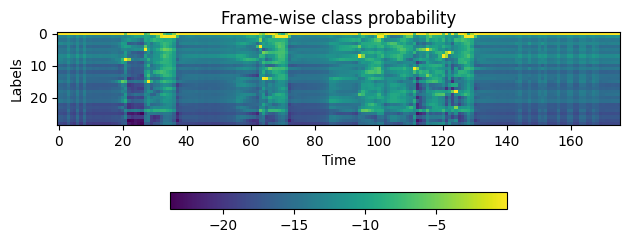

In [ ]:
def plot():
    fig, ax = plt.subplots()
    img = ax.imshow(emission.T)
    ax.set_title("Frame-wise class probability")
    ax.set_xlabel("Time")
    ax.set_ylabel("Labels")
    fig.colorbar(img, ax=ax, shrink=0.6, location="bottom")
    fig.tight_layout()


plot()

In [ ]:
if 'english1' in audio_path:
  transcript = "|HELLO|EVERYONE|"
if 'english2' in audio_path:
  transcript = "|HOW|ARE|YOU|DOING|"
if 'hard_english1' in audio_path:
  transcript = "|THE|EARTH|IS|FLAT|"
if 'hard_english2' in audio_path:
  transcript = "|THE|PEN|IS|MIGHTIER|THAN|THE|SWORD|"
if 'diff2' in audio_path:
  transcript = "|But|what|I|do|that|defines|me|"
transcript = transcript.upper()
print(transcript)
dictionary = {c: i for i, c in enumerate(labels)}

tokens = [dictionary[c] for c in transcript]
print(list(zip(transcript, tokens)))


def get_trellis(emission, tokens, blank_id=0):
    num_frame = emission.size(0)
    num_tokens = len(tokens)

    trellis = torch.zeros((num_frame, num_tokens))
    trellis[1:, 0] = torch.cumsum(emission[1:, blank_id], 0)
    trellis[0, 1:] = -float("inf")
    trellis[-num_tokens + 1 :, 0] = float("inf")

    for t in range(num_frame - 1):
        trellis[t + 1, 1:] = torch.maximum(
            # Score for staying at the same token
            trellis[t, 1:] + emission[t, blank_id],
            # Score for changing to the next token
            trellis[t, :-1] + emission[t, tokens[1:]],
        )
    return trellis


trellis = get_trellis(emission, tokens)

|HOW|ARE|YOU|DOING|
[('|', 1), ('H', 8), ('O', 5), ('W', 15), ('|', 1), ('A', 4), ('R', 10), ('E', 2), ('|', 1), ('Y', 19), ('O', 5), ('U', 13), ('|', 1), ('D', 11), ('O', 5), ('I', 7), ('N', 6), ('G', 18), ('|', 1)]


Point(token_index=0, time_index=0, score=0.9999788999557495)
Point(token_index=0, time_index=1, score=0.999981164932251)
Point(token_index=0, time_index=2, score=0.999987006187439)
Point(token_index=0, time_index=3, score=0.9999423027038574)
Point(token_index=0, time_index=4, score=0.9999872446060181)
Point(token_index=0, time_index=5, score=0.999992847442627)
Point(token_index=0, time_index=6, score=0.9999423027038574)
Point(token_index=0, time_index=7, score=0.9999914169311523)
Point(token_index=0, time_index=8, score=0.9999423027038574)
Point(token_index=0, time_index=9, score=0.9999912977218628)
Point(token_index=0, time_index=10, score=0.9999904632568359)
Point(token_index=0, time_index=11, score=0.9999926090240479)
Point(token_index=0, time_index=12, score=0.9999918937683105)
Point(token_index=0, time_index=13, score=0.9999914169311523)
Point(token_index=0, time_index=14, score=0.9999921321868896)
Point(token_index=0, time_index=15, score=0.999991774559021)
Point(token_index=0, t

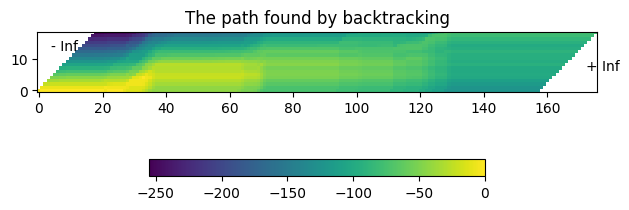

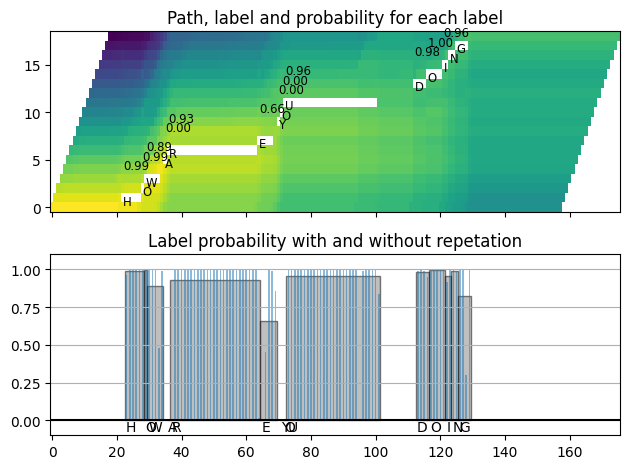

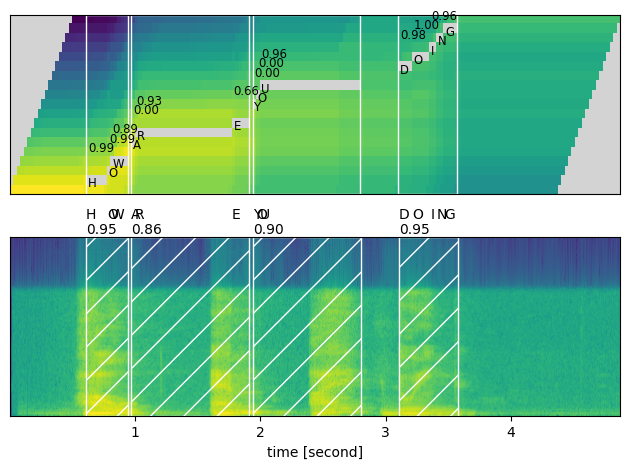

In [ ]:
def plot():
    fig, ax = plt.subplots()
    img = ax.imshow(trellis.T, origin="lower")
    ax.annotate("- Inf", (trellis.size(1) / 5, trellis.size(1) / 1.5))
    ax.annotate("+ Inf", (trellis.size(0) - trellis.size(1) / 5, trellis.size(1) / 3))
    fig.colorbar(img, ax=ax, shrink=0.6, location="bottom")
    fig.tight_layout()


plot()

from dataclasses import dataclass

@dataclass
class Point:
    token_index: int
    time_index: int
    score: float


def backtrack(trellis, emission, tokens, blank_id=0):
    t, j = trellis.size(0) - 1, trellis.size(1) - 1

    path = [Point(j, t, emission[t, blank_id].exp().item())]
    while j > 0:
        # Should not happen but just in case
        assert t > 0

        # 1. Figure out if the current position was stay or change
        # Frame-wise score of stay vs change
        p_stay = emission[t - 1, blank_id]
        p_change = emission[t - 1, tokens[j]]

        # Context-aware score for stay vs change
        stayed = trellis[t - 1, j] + p_stay
        changed = trellis[t - 1, j - 1] + p_change

        # Update position
        t -= 1
        if changed > stayed:
            j -= 1

        # Store the path with frame-wise probability.
        prob = (p_change if changed > stayed else p_stay).exp().item()
        path.append(Point(j, t, prob))

    # Now j == 0, which means, it reached the SoS.
    # Fill up the rest for the sake of visualization
    while t > 0:
        prob = emission[t - 1, blank_id].exp().item()
        path.append(Point(j, t - 1, prob))
        t -= 1

    return path[::-1]


path = backtrack(trellis, emission, tokens)
for p in path:
    print(p)

def plot_trellis_with_path(trellis, path):
    # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    for _, p in enumerate(path):
        trellis_with_path[p.time_index, p.token_index] = float("nan")
    plt.imshow(trellis_with_path.T, origin="lower")
    plt.title("The path found by backtracking")
    plt.tight_layout()


plot_trellis_with_path(trellis, path)

# Merge the labels
@dataclass
class Segment:
    label: str
    start: int
    end: int
    score: float

    def _repr_(self):
        return f"{self.label}\t({self.score:4.2f}): [{self.start:5d}, {self.end:5d})"

    @property
    def length(self):
        return self.end - self.start


def merge_repeats(path):
    i1, i2 = 0, 0
    segments = []
    while i1 < len(path):
        while i2 < len(path) and path[i1].token_index == path[i2].token_index:
            i2 += 1
        score = sum(path[k].score for k in range(i1, i2)) / (i2 - i1)
        segments.append(
            Segment(
                transcript[path[i1].token_index],
                path[i1].time_index,
                path[i2 - 1].time_index + 1,
                score,
            )
        )
        i1 = i2
    return segments


segments = merge_repeats(path)
for seg in segments:
    print(seg)

def plot_trellis_with_segments(trellis, segments, transcript):
    # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != "|":
            trellis_with_path[seg.start : seg.end, i] = float("nan")

    fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True)
    ax1.set_title("Path, label and probability for each label")
    ax1.imshow(trellis_with_path.T, origin="lower", aspect="auto")

    for i, seg in enumerate(segments):
        if seg.label != "|":
            ax1.annotate(seg.label, (seg.start, i - 0.7), size="small")
            ax1.annotate(f"{seg.score:.2f}", (seg.start, i + 3), size="small")

    ax2.set_title("Label probability with and without repetation")
    xs, hs, ws = [], [], []
    for seg in segments:
        if seg.label != "|":
            xs.append((seg.end + seg.start) / 2 + 0.4)
            hs.append(seg.score)
            ws.append(seg.end - seg.start)
            ax2.annotate(seg.label, (seg.start + 0.8, -0.07))
    ax2.bar(xs, hs, width=ws, color="gray", alpha=0.5, edgecolor="black")

    xs, hs = [], []
    for p in path:
        label = transcript[p.token_index]
        if label != "|":
            xs.append(p.time_index + 1)
            hs.append(p.score)

    ax2.bar(xs, hs, width=0.5, alpha=0.5)
    ax2.axhline(0, color="black")
    ax2.grid(True, axis="y")
    ax2.set_ylim(-0.1, 1.1)
    fig.tight_layout()


plot_trellis_with_segments(trellis, segments, transcript)

# Merge words
def merge_words(segments, separator="|"):
    words = []
    i1, i2 = 0, 0
    while i1 < len(segments):
        if i2 >= len(segments) or segments[i2].label == separator:
            if i1 != i2:
                segs = segments[i1:i2]
                word = "".join([seg.label for seg in segs])
                score = sum(seg.score * seg.length for seg in segs) / sum(seg.length for seg in segs)
                words.append(Segment(word, segments[i1].start, segments[i2 - 1].end, score))
            i1 = i2 + 1
            i2 = i1
        else:
            i2 += 1
    return words


word_segments = merge_words(segments)
for word in word_segments:
    print(word)

import librosa

# Load the audio file
waveform, sample_rate = librosa.load(audio_path)

def plot_alignments(trellis, segments, word_segments, waveform, sample_rate=16000):
    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != "|":
            trellis_with_path[seg.start : seg.end, i] = float("nan")

    fig, [ax1, ax2] = plt.subplots(2, 1)

    ax1.imshow(trellis_with_path.T, origin="lower", aspect="auto")
    ax1.set_facecolor("lightgray")
    ax1.set_xticks([])
    ax1.set_yticks([])

    for word in word_segments:
        ax1.axvspan(word.start - 0.5, word.end - 0.5, edgecolor="white", facecolor="none")

    for i, seg in enumerate(segments):
        if seg.label != "|":
            ax1.annotate(seg.label, (seg.start, i - 0.7), size="small")
            ax1.annotate(f"{seg.score:.2f}", (seg.start, i + 3), size="small")

    # The original waveform
    ratio = len(waveform) / sample_rate / trellis.size(0)
    ax2.specgram(waveform, Fs=sample_rate)
    for word in word_segments:
        x0 = ratio * word.start
        x1 = ratio * word.end
        ax2.axvspan(x0, x1, facecolor="none", edgecolor="white", hatch="/")
        ax2.annotate(f"{word.score:.2f}", (x0, sample_rate * 0.51), annotation_clip=False)

    for seg in segments:
        if seg.label != "|":
            ax2.annotate(seg.label, (seg.start * ratio, sample_rate * 0.55), annotation_clip=False)
    ax2.set_xlabel("time [second]")
    ax2.set_yticks([])
    fig.tight_layout()


plot_alignments(trellis, segments, word_segments, waveform)

sample_rate = 16000
def display_segment(i):
    ratio = len(waveform) / trellis.size(0)
    word = word_segments[i]
    x0 = int(ratio * word.start)
    x1 = int(ratio * word.end)
    print(f"{word.label} ({word.score:.2f}): {x0 / sample_rate:.3f} - {x1 / sample_rate:.3f} sec")
    segment = waveform[x0:x1]
    return IPython.display.Audio(segment, rate=sample_rate)

import IPython
# Generate the audio for each segment
print(transcript)
IPython.display.Audio(audio_path)



# display_segment(2)

In [ ]:
display_segment(0)

HOW (0.95): 0.610 - 0.942 sec


In [ ]:
display_segment(1)


ARE (0.86): 0.970 - 1.913 sec


In [ ]:
display_segment(2)


YOU (0.90): 1.940 - 2.800 sec


In [ ]:
display_segment(3)


DOING (0.95): 3.104 - 3.576 sec


In [ ]:
from dataclasses import dataclass

import IPython
import matplotlib.pyplot as plt

torch.random.manual_seed(0)
audio_path = "/content/drive/MyDrive/easy_english1.wav"
# audio_path = "/content/drive/MyDrive/easy_english1_mispronounced.wav"
# audio_path = "/content/drive/MyDrive/easy_english2.wav"
# audio_path = "/content/drive/MyDrive/easy_english2_mispronounced.wav"
# audio_path = "/content/drive/MyDrive/hard_english1.wav"
# audio_path = "/content/drive/MyDrive/hard_english1_replaced.wav"
# audio_path = "/content/drive/MyDrive/hard_english2.wav"
# audio_path = "/content/drive/MyDrive/hard_english2_noisy.wav"
# audio_path = "/content/drive/MyDrive/Copy of easy_smooth_english.wav"
# audio_path = "/content/drive/MyDrive/Copy of easy_mispronounce_english.wav"
# audio_path = "/content/drive/MyDrive/Copy of diff2_smooth_english.wav"
# audio_path = "/content/drive/MyDrive/Copy of diff2_mispronounce_english.wav"
SPEECH_FILE = torchaudio.utils.download_asset(audio_path)

In [ ]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
model = bundle.get_model().to(device)
labels = bundle.get_labels()
with torch.inference_mode():
    waveform, _ = torchaudio.load(SPEECH_FILE)
    emissions, _ = model(waveform.to(device))
    emissions = torch.log_softmax(emissions, dim=-1)

emission = emissions[0].cpu().detach()

print(labels)

('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


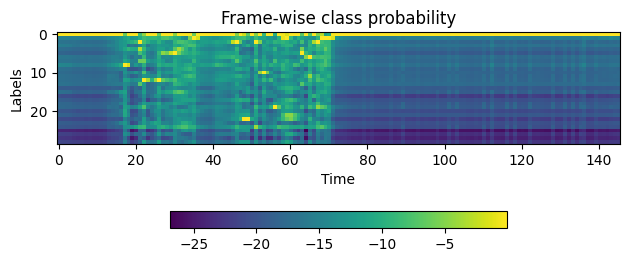

In [ ]:
def plot():
    fig, ax = plt.subplots()
    img = ax.imshow(emission.T)
    ax.set_title("Frame-wise class probability")
    ax.set_xlabel("Time")
    ax.set_ylabel("Labels")
    fig.colorbar(img, ax=ax, shrink=0.6, location="bottom")
    fig.tight_layout()


plot()

In [ ]:
if 'english1' in audio_path:
  transcript = "|HELLO|EVERYONE|"
if 'english2' in audio_path:
  transcript = "|HOW|ARE|YOU|DOING|"
if 'hard_english1' in audio_path:
  transcript = "|THE|EARTH|IS|FLAT|"
if 'hard_english2' in audio_path:
  transcript = "|THE|PEN|IS|MIGHTIER|THAN|THE|SWORD|"
if 'diff2' in audio_path:
  transcript = "|But|what|I|do|that|defines|me|"
transcript = transcript.upper()
print(transcript)
dictionary = {c: i for i, c in enumerate(labels)}

tokens = [dictionary[c] for c in transcript]
print(list(zip(transcript, tokens)))


def get_trellis(emission, tokens, blank_id=0):
    num_frame = emission.size(0)
    num_tokens = len(tokens)

    trellis = torch.zeros((num_frame, num_tokens))
    trellis[1:, 0] = torch.cumsum(emission[1:, blank_id], 0)
    trellis[0, 1:] = -float("inf")
    trellis[-num_tokens + 1 :, 0] = float("inf")

    for t in range(num_frame - 1):
        trellis[t + 1, 1:] = torch.maximum(
            # Score for staying at the same token
            trellis[t, 1:] + emission[t, blank_id],
            # Score for changing to the next token
            trellis[t, :-1] + emission[t, tokens[1:]],
        )
    return trellis


trellis = get_trellis(emission, tokens)

|HELLO|EVERYONE|
[('|', 1), ('H', 8), ('E', 2), ('L', 12), ('L', 12), ('O', 5), ('|', 1), ('E', 2), ('V', 22), ('E', 2), ('R', 10), ('Y', 19), ('O', 5), ('N', 6), ('E', 2), ('|', 1)]


Point(token_index=0, time_index=0, score=0.9999984502792358)
Point(token_index=0, time_index=1, score=0.9999984502792358)
Point(token_index=0, time_index=2, score=0.9999988079071045)
Point(token_index=0, time_index=3, score=0.999998927116394)
Point(token_index=0, time_index=4, score=0.9999992847442627)
Point(token_index=0, time_index=5, score=0.9999992847442627)
Point(token_index=0, time_index=6, score=0.9999992847442627)
Point(token_index=0, time_index=7, score=0.9999994039535522)
Point(token_index=0, time_index=8, score=0.9999992847442627)
Point(token_index=0, time_index=9, score=0.9999994039535522)
Point(token_index=0, time_index=10, score=0.9999994039535522)
Point(token_index=0, time_index=11, score=0.9999992847442627)
Point(token_index=0, time_index=12, score=0.999998927116394)
Point(token_index=0, time_index=13, score=0.9999974966049194)
Point(token_index=0, time_index=14, score=0.9999955892562866)
Point(token_index=0, time_index=15, score=0.9999898672103882)
Point(token_index=0,

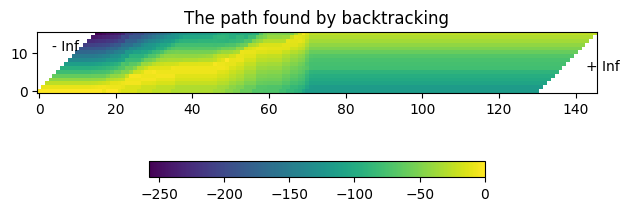

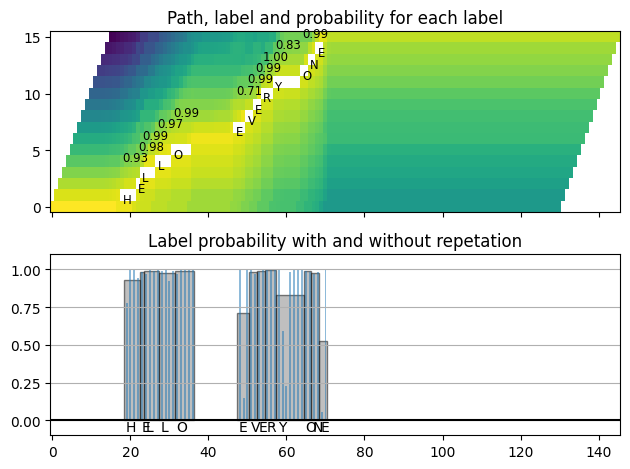

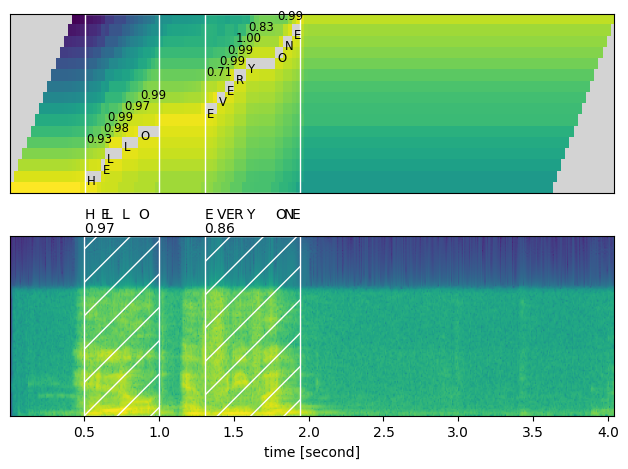

In [ ]:
def plot():
    fig, ax = plt.subplots()
    img = ax.imshow(trellis.T, origin="lower")
    ax.annotate("- Inf", (trellis.size(1) / 5, trellis.size(1) / 1.5))
    ax.annotate("+ Inf", (trellis.size(0) - trellis.size(1) / 5, trellis.size(1) / 3))
    fig.colorbar(img, ax=ax, shrink=0.6, location="bottom")
    fig.tight_layout()


plot()

from dataclasses import dataclass

@dataclass
class Point:
    token_index: int
    time_index: int
    score: float


def backtrack(trellis, emission, tokens, blank_id=0):
    t, j = trellis.size(0) - 1, trellis.size(1) - 1

    path = [Point(j, t, emission[t, blank_id].exp().item())]
    while j > 0:
        # Should not happen but just in case
        assert t > 0

        # 1. Figure out if the current position was stay or change
        # Frame-wise score of stay vs change
        p_stay = emission[t - 1, blank_id]
        p_change = emission[t - 1, tokens[j]]

        # Context-aware score for stay vs change
        stayed = trellis[t - 1, j] + p_stay
        changed = trellis[t - 1, j - 1] + p_change

        # Update position
        t -= 1
        if changed > stayed:
            j -= 1

        # Store the path with frame-wise probability.
        prob = (p_change if changed > stayed else p_stay).exp().item()
        path.append(Point(j, t, prob))

    # Now j == 0, which means, it reached the SoS.
    # Fill up the rest for the sake of visualization
    while t > 0:
        prob = emission[t - 1, blank_id].exp().item()
        path.append(Point(j, t - 1, prob))
        t -= 1

    return path[::-1]


path = backtrack(trellis, emission, tokens)
for p in path:
    print(p)

def plot_trellis_with_path(trellis, path):
    # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    for _, p in enumerate(path):
        trellis_with_path[p.time_index, p.token_index] = float("nan")
    plt.imshow(trellis_with_path.T, origin="lower")
    plt.title("The path found by backtracking")
    plt.tight_layout()


plot_trellis_with_path(trellis, path)

# Merge the labels
@dataclass
class Segment:
    label: str
    start: int
    end: int
    score: float

    def _repr_(self):
        return f"{self.label}\t({self.score:4.2f}): [{self.start:5d}, {self.end:5d})"

    @property
    def length(self):
        return self.end - self.start


def merge_repeats(path):
    i1, i2 = 0, 0
    segments = []
    while i1 < len(path):
        while i2 < len(path) and path[i1].token_index == path[i2].token_index:
            i2 += 1
        score = sum(path[k].score for k in range(i1, i2)) / (i2 - i1)
        segments.append(
            Segment(
                transcript[path[i1].token_index],
                path[i1].time_index,
                path[i2 - 1].time_index + 1,
                score,
            )
        )
        i1 = i2
    return segments


segments = merge_repeats(path)
for seg in segments:
    print(seg)

def plot_trellis_with_segments(trellis, segments, transcript):
    # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != "|":
            trellis_with_path[seg.start : seg.end, i] = float("nan")

    fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True)
    ax1.set_title("Path, label and probability for each label")
    ax1.imshow(trellis_with_path.T, origin="lower", aspect="auto")

    for i, seg in enumerate(segments):
        if seg.label != "|":
            ax1.annotate(seg.label, (seg.start, i - 0.7), size="small")
            ax1.annotate(f"{seg.score:.2f}", (seg.start, i + 3), size="small")

    ax2.set_title("Label probability with and without repetation")
    xs, hs, ws = [], [], []
    for seg in segments:
        if seg.label != "|":
            xs.append((seg.end + seg.start) / 2 + 0.4)
            hs.append(seg.score)
            ws.append(seg.end - seg.start)
            ax2.annotate(seg.label, (seg.start + 0.8, -0.07))
    ax2.bar(xs, hs, width=ws, color="gray", alpha=0.5, edgecolor="black")

    xs, hs = [], []
    for p in path:
        label = transcript[p.token_index]
        if label != "|":
            xs.append(p.time_index + 1)
            hs.append(p.score)

    ax2.bar(xs, hs, width=0.5, alpha=0.5)
    ax2.axhline(0, color="black")
    ax2.grid(True, axis="y")
    ax2.set_ylim(-0.1, 1.1)
    fig.tight_layout()


plot_trellis_with_segments(trellis, segments, transcript)

# Merge words
def merge_words(segments, separator="|"):
    words = []
    i1, i2 = 0, 0
    while i1 < len(segments):
        if i2 >= len(segments) or segments[i2].label == separator:
            if i1 != i2:
                segs = segments[i1:i2]
                word = "".join([seg.label for seg in segs])
                score = sum(seg.score * seg.length for seg in segs) / sum(seg.length for seg in segs)
                words.append(Segment(word, segments[i1].start, segments[i2 - 1].end, score))
            i1 = i2 + 1
            i2 = i1
        else:
            i2 += 1
    return words


word_segments = merge_words(segments)
for word in word_segments:
    print(word)

import librosa

# Load the audio file
waveform, sample_rate = librosa.load(audio_path)

def plot_alignments(trellis, segments, word_segments, waveform, sample_rate=16000):
    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != "|":
            trellis_with_path[seg.start : seg.end, i] = float("nan")

    fig, [ax1, ax2] = plt.subplots(2, 1)

    ax1.imshow(trellis_with_path.T, origin="lower", aspect="auto")
    ax1.set_facecolor("lightgray")
    ax1.set_xticks([])
    ax1.set_yticks([])

    for word in word_segments:
        ax1.axvspan(word.start - 0.5, word.end - 0.5, edgecolor="white", facecolor="none")

    for i, seg in enumerate(segments):
        if seg.label != "|":
            ax1.annotate(seg.label, (seg.start, i - 0.7), size="small")
            ax1.annotate(f"{seg.score:.2f}", (seg.start, i + 3), size="small")

    # The original waveform
    ratio = len(waveform) / sample_rate / trellis.size(0)
    ax2.specgram(waveform, Fs=sample_rate)
    for word in word_segments:
        x0 = ratio * word.start
        x1 = ratio * word.end
        ax2.axvspan(x0, x1, facecolor="none", edgecolor="white", hatch="/")
        ax2.annotate(f"{word.score:.2f}", (x0, sample_rate * 0.51), annotation_clip=False)

    for seg in segments:
        if seg.label != "|":
            ax2.annotate(seg.label, (seg.start * ratio, sample_rate * 0.55), annotation_clip=False)
    ax2.set_xlabel("time [second]")
    ax2.set_yticks([])
    fig.tight_layout()


plot_alignments(trellis, segments, word_segments, waveform)

sample_rate = 16000
def display_segment(i):
    ratio = len(waveform) / trellis.size(0)
    word = word_segments[i]
    x0 = int(ratio * word.start)
    x1 = int(ratio * word.end)
    print(f"{word.label} ({word.score:.2f}): {x0 / sample_rate:.3f} - {x1 / sample_rate:.3f} sec")
    segment = waveform[x0:x1]
    return IPython.display.Audio(segment, rate=sample_rate)

import IPython
# Generate the audio for each segment
print(transcript)
IPython.display.Audio(audio_path)



# display_segment(2)

In [ ]:
display_segment(0)

HELLO (0.97): 0.499 - 0.999 sec


In [ ]:
display_segment(1)


EVERYONE (0.86): 1.304 - 1.943 sec


In [ ]:
from dataclasses import dataclass

import IPython
import matplotlib.pyplot as plt

torch.random.manual_seed(0)
# audio_path = "/content/drive/MyDrive/easy_english1.wav"
audio_path = "/content/drive/MyDrive/easy_english1_mispronounced.wav"
# audio_path = "/content/drive/MyDrive/easy_english2.wav"
# audio_path = "/content/drive/MyDrive/easy_english2_mispronounced.wav"
# audio_path = "/content/drive/MyDrive/hard_english1.wav"
# audio_path = "/content/drive/MyDrive/hard_english1_replaced.wav"
# audio_path = "/content/drive/MyDrive/hard_english2.wav"
# audio_path = "/content/drive/MyDrive/hard_english2_noisy.wav"
# audio_path = "/content/drive/MyDrive/Copy of easy_smooth_english.wav"
# audio_path = "/content/drive/MyDrive/Copy of easy_mispronounce_english.wav"
# audio_path = "/content/drive/MyDrive/Copy of diff2_smooth_english.wav"
# audio_path = "/content/drive/MyDrive/Copy of diff2_mispronounce_english.wav"
SPEECH_FILE = torchaudio.utils.download_asset(audio_path)

In [ ]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
model = bundle.get_model().to(device)
labels = bundle.get_labels()
with torch.inference_mode():
    waveform, _ = torchaudio.load(SPEECH_FILE)
    emissions, _ = model(waveform.to(device))
    emissions = torch.log_softmax(emissions, dim=-1)

emission = emissions[0].cpu().detach()

print(labels)

('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


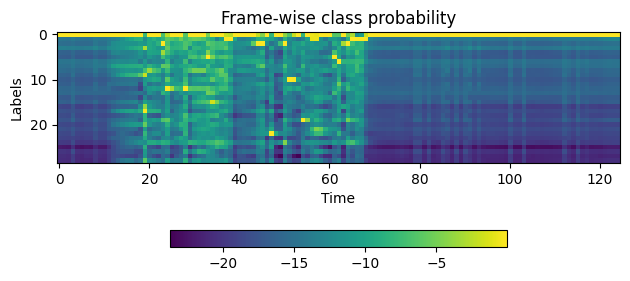

In [ ]:
def plot():
    fig, ax = plt.subplots()
    img = ax.imshow(emission.T)
    ax.set_title("Frame-wise class probability")
    ax.set_xlabel("Time")
    ax.set_ylabel("Labels")
    fig.colorbar(img, ax=ax, shrink=0.6, location="bottom")
    fig.tight_layout()


plot()

In [ ]:
if 'english1' in audio_path:
  transcript = "|HELLO|EVERYONE|"
if 'english2' in audio_path:
  transcript = "|HOW|ARE|YOU|DOING|"
if 'hard_english1' in audio_path:
  transcript = "|THE|EARTH|IS|FLAT|"
if 'hard_english2' in audio_path:
  transcript = "|THE|PEN|IS|MIGHTIER|THAN|THE|SWORD|"
if 'diff2' in audio_path:
  transcript = "|But|what|I|do|that|defines|me|"
transcript = transcript.upper()
print(transcript)
dictionary = {c: i for i, c in enumerate(labels)}

tokens = [dictionary[c] for c in transcript]
print(list(zip(transcript, tokens)))


def get_trellis(emission, tokens, blank_id=0):
    num_frame = emission.size(0)
    num_tokens = len(tokens)

    trellis = torch.zeros((num_frame, num_tokens))
    trellis[1:, 0] = torch.cumsum(emission[1:, blank_id], 0)
    trellis[0, 1:] = -float("inf")
    trellis[-num_tokens + 1 :, 0] = float("inf")

    for t in range(num_frame - 1):
        trellis[t + 1, 1:] = torch.maximum(
            # Score for staying at the same token
            trellis[t, 1:] + emission[t, blank_id],
            # Score for changing to the next token
            trellis[t, :-1] + emission[t, tokens[1:]],
        )
    return trellis


trellis = get_trellis(emission, tokens)

|HELLO|EVERYONE|
[('|', 1), ('H', 8), ('E', 2), ('L', 12), ('L', 12), ('O', 5), ('|', 1), ('E', 2), ('V', 22), ('E', 2), ('R', 10), ('Y', 19), ('O', 5), ('N', 6), ('E', 2), ('|', 1)]


Point(token_index=0, time_index=0, score=0.9999957084655762)
Point(token_index=0, time_index=1, score=0.9999960660934448)
Point(token_index=0, time_index=2, score=0.9999966621398926)
Point(token_index=0, time_index=3, score=0.9999942779541016)
Point(token_index=0, time_index=4, score=0.9999970197677612)
Point(token_index=0, time_index=5, score=0.9999974966049194)
Point(token_index=0, time_index=6, score=0.9999969005584717)
Point(token_index=0, time_index=7, score=0.9999970197677612)
Point(token_index=0, time_index=8, score=0.9999920129776001)
Point(token_index=0, time_index=9, score=0.9999963045120239)
Point(token_index=0, time_index=10, score=0.9999963045120239)
Point(token_index=0, time_index=11, score=0.9999877214431763)
Point(token_index=0, time_index=12, score=0.9999396800994873)
Point(token_index=0, time_index=13, score=0.9998849630355835)
Point(token_index=0, time_index=14, score=0.9998034834861755)
Point(token_index=0, time_index=15, score=0.9996128678321838)
Point(token_index=

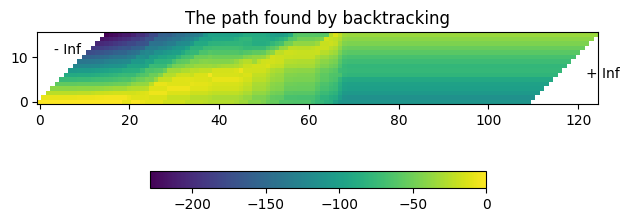

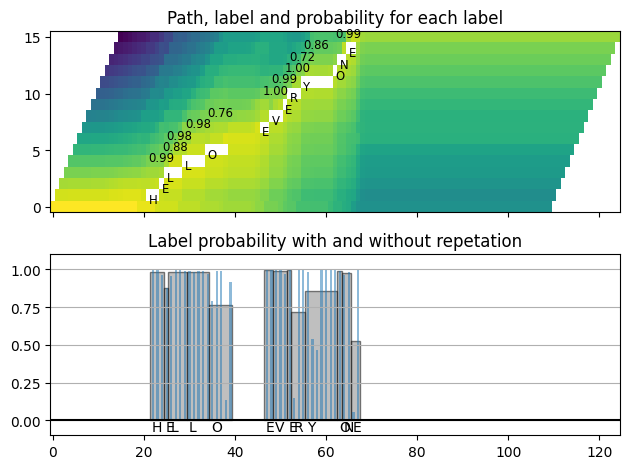

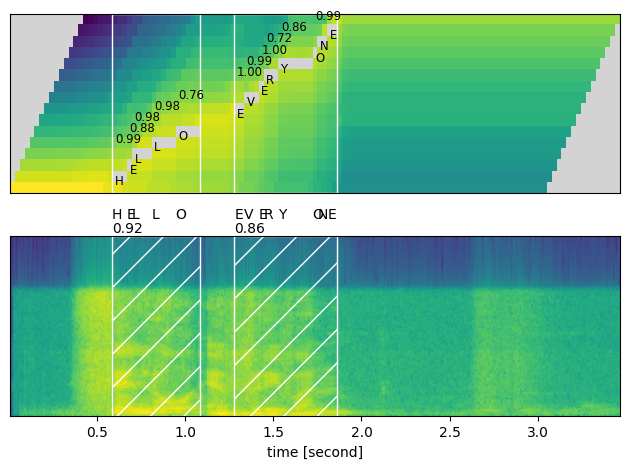

In [ ]:
def plot():
    fig, ax = plt.subplots()
    img = ax.imshow(trellis.T, origin="lower")
    ax.annotate("- Inf", (trellis.size(1) / 5, trellis.size(1) / 1.5))
    ax.annotate("+ Inf", (trellis.size(0) - trellis.size(1) / 5, trellis.size(1) / 3))
    fig.colorbar(img, ax=ax, shrink=0.6, location="bottom")
    fig.tight_layout()


plot()

from dataclasses import dataclass

@dataclass
class Point:
    token_index: int
    time_index: int
    score: float


def backtrack(trellis, emission, tokens, blank_id=0):
    t, j = trellis.size(0) - 1, trellis.size(1) - 1

    path = [Point(j, t, emission[t, blank_id].exp().item())]
    while j > 0:
        # Should not happen but just in case
        assert t > 0

        # 1. Figure out if the current position was stay or change
        # Frame-wise score of stay vs change
        p_stay = emission[t - 1, blank_id]
        p_change = emission[t - 1, tokens[j]]

        # Context-aware score for stay vs change
        stayed = trellis[t - 1, j] + p_stay
        changed = trellis[t - 1, j - 1] + p_change

        # Update position
        t -= 1
        if changed > stayed:
            j -= 1

        # Store the path with frame-wise probability.
        prob = (p_change if changed > stayed else p_stay).exp().item()
        path.append(Point(j, t, prob))

    # Now j == 0, which means, it reached the SoS.
    # Fill up the rest for the sake of visualization
    while t > 0:
        prob = emission[t - 1, blank_id].exp().item()
        path.append(Point(j, t - 1, prob))
        t -= 1

    return path[::-1]


path = backtrack(trellis, emission, tokens)
for p in path:
    print(p)

def plot_trellis_with_path(trellis, path):
    # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    for _, p in enumerate(path):
        trellis_with_path[p.time_index, p.token_index] = float("nan")
    plt.imshow(trellis_with_path.T, origin="lower")
    plt.title("The path found by backtracking")
    plt.tight_layout()


plot_trellis_with_path(trellis, path)

# Merge the labels
@dataclass
class Segment:
    label: str
    start: int
    end: int
    score: float

    def _repr_(self):
        return f"{self.label}\t({self.score:4.2f}): [{self.start:5d}, {self.end:5d})"

    @property
    def length(self):
        return self.end - self.start


def merge_repeats(path):
    i1, i2 = 0, 0
    segments = []
    while i1 < len(path):
        while i2 < len(path) and path[i1].token_index == path[i2].token_index:
            i2 += 1
        score = sum(path[k].score for k in range(i1, i2)) / (i2 - i1)
        segments.append(
            Segment(
                transcript[path[i1].token_index],
                path[i1].time_index,
                path[i2 - 1].time_index + 1,
                score,
            )
        )
        i1 = i2
    return segments


segments = merge_repeats(path)
for seg in segments:
    print(seg)

def plot_trellis_with_segments(trellis, segments, transcript):
    # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != "|":
            trellis_with_path[seg.start : seg.end, i] = float("nan")

    fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True)
    ax1.set_title("Path, label and probability for each label")
    ax1.imshow(trellis_with_path.T, origin="lower", aspect="auto")

    for i, seg in enumerate(segments):
        if seg.label != "|":
            ax1.annotate(seg.label, (seg.start, i - 0.7), size="small")
            ax1.annotate(f"{seg.score:.2f}", (seg.start, i + 3), size="small")

    ax2.set_title("Label probability with and without repetation")
    xs, hs, ws = [], [], []
    for seg in segments:
        if seg.label != "|":
            xs.append((seg.end + seg.start) / 2 + 0.4)
            hs.append(seg.score)
            ws.append(seg.end - seg.start)
            ax2.annotate(seg.label, (seg.start + 0.8, -0.07))
    ax2.bar(xs, hs, width=ws, color="gray", alpha=0.5, edgecolor="black")

    xs, hs = [], []
    for p in path:
        label = transcript[p.token_index]
        if label != "|":
            xs.append(p.time_index + 1)
            hs.append(p.score)

    ax2.bar(xs, hs, width=0.5, alpha=0.5)
    ax2.axhline(0, color="black")
    ax2.grid(True, axis="y")
    ax2.set_ylim(-0.1, 1.1)
    fig.tight_layout()


plot_trellis_with_segments(trellis, segments, transcript)

# Merge words
def merge_words(segments, separator="|"):
    words = []
    i1, i2 = 0, 0
    while i1 < len(segments):
        if i2 >= len(segments) or segments[i2].label == separator:
            if i1 != i2:
                segs = segments[i1:i2]
                word = "".join([seg.label for seg in segs])
                score = sum(seg.score * seg.length for seg in segs) / sum(seg.length for seg in segs)
                words.append(Segment(word, segments[i1].start, segments[i2 - 1].end, score))
            i1 = i2 + 1
            i2 = i1
        else:
            i2 += 1
    return words


word_segments = merge_words(segments)
for word in word_segments:
    print(word)

import librosa

# Load the audio file
waveform, sample_rate = librosa.load(audio_path)

def plot_alignments(trellis, segments, word_segments, waveform, sample_rate=16000):
    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != "|":
            trellis_with_path[seg.start : seg.end, i] = float("nan")

    fig, [ax1, ax2] = plt.subplots(2, 1)

    ax1.imshow(trellis_with_path.T, origin="lower", aspect="auto")
    ax1.set_facecolor("lightgray")
    ax1.set_xticks([])
    ax1.set_yticks([])

    for word in word_segments:
        ax1.axvspan(word.start - 0.5, word.end - 0.5, edgecolor="white", facecolor="none")

    for i, seg in enumerate(segments):
        if seg.label != "|":
            ax1.annotate(seg.label, (seg.start, i - 0.7), size="small")
            ax1.annotate(f"{seg.score:.2f}", (seg.start, i + 3), size="small")

    # The original waveform
    ratio = len(waveform) / sample_rate / trellis.size(0)
    ax2.specgram(waveform, Fs=sample_rate)
    for word in word_segments:
        x0 = ratio * word.start
        x1 = ratio * word.end
        ax2.axvspan(x0, x1, facecolor="none", edgecolor="white", hatch="/")
        ax2.annotate(f"{word.score:.2f}", (x0, sample_rate * 0.51), annotation_clip=False)

    for seg in segments:
        if seg.label != "|":
            ax2.annotate(seg.label, (seg.start * ratio, sample_rate * 0.55), annotation_clip=False)
    ax2.set_xlabel("time [second]")
    ax2.set_yticks([])
    fig.tight_layout()


plot_alignments(trellis, segments, word_segments, waveform)

sample_rate = 16000
def display_segment(i):
    ratio = len(waveform) / trellis.size(0)
    word = word_segments[i]
    x0 = int(ratio * word.start)
    x1 = int(ratio * word.end)
    print(f"{word.label} ({word.score:.2f}): {x0 / sample_rate:.3f} - {x1 / sample_rate:.3f} sec")
    segment = waveform[x0:x1]
    return IPython.display.Audio(segment, rate=sample_rate)

import IPython
# Generate the audio for each segment
print(transcript)
IPython.display.Audio(audio_path)



# display_segment(2)

In [ ]:
display_segment(0)

HELLO (0.92): 0.583 - 1.083 sec


In [ ]:
display_segment(1)


EVERYONE (0.86): 1.278 - 1.861 sec
